In [2]:
import pickle
import os
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.io import gbq
from google.cloud import bigquery
from google.oauth2 import service_account

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
% config InlineBackend . figure_format = 'svg'

In [3]:
# This cell is just about making things look nice
# Make plots bigger by default.
# Has to occur after the %matplotlib inline in a different cell. Known issue
plt.rc('figure', figsize=(12.0, 6.0))
matplotlib.rcParams.update({'font.size': 22})

# Make numpy outputs easier to read
np.set_printoptions(precision=3, formatter={'float': '{: 8.3f}'.format})

In [4]:
## Set up bigquery environment

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/ubuntu/certs/stackoverflow-metis-32ecb3fa04c0.json"
project_id = 'stackoverflow-metis'
client = bigquery.Client(project=project_id)
dataset_id = 'SO_dataset'
dataset_ref = client.dataset(dataset_id)
dataset = client.get_dataset(dataset_ref)

## Create a view to reconstruct user reputation at 01/01/2017 and 01/01/2018


In [ ]:
## Create a view to reconstruct user reputation at 01/01/2017 and 01/01/2018
view_ref = dataset_ref.table('SO_user_reputation_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
  user.id,
  LENGTH(about_me) AS about_me_length,
  user.age,
  user.creation_date,
  user.last_access_date,
  user.location,
  user.reputation,
  user.up_votes,
  user.down_votes,
  user.profile_image_url,
  user.website_url,
  answer_2017.answer_reputation_total_2017,
  question_2017.question_reputation_total_2017,
  accepted_2017.accepted_reputation_total_2017,
  answer_2018.answer_reputation_total_2018,
  question_2018.question_reputation_total_2018,
  accepted_2018.accepted_reputation_total_2018
FROM
  `bigquery-public-data.stackoverflow.users` AS user
LEFT JOIN (
  SELECT
    owner_user_id,
    SUM(answer_reputation) AS answer_reputation_total_2017
  FROM (
    SELECT
      owner_user_id,
      score * 10 AS answer_reputation
    FROM
      `bigquery-public-data.stackoverflow.posts_answers`
    WHERE
      creation_date < '2017-01-01 00:00:00')
  GROUP BY
    owner_user_id) AS answer_2017
ON
  user.id = answer_2017.owner_user_id
LEFT JOIN (
  SELECT
    owner_user_id,
    SUM(question_reputation) AS question_reputation_total_2017
  FROM (
    SELECT
      owner_user_id,
      score * 5 AS question_reputation
    FROM
      `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
      creation_date < '2017-01-01 00:00:00')
  GROUP BY
    owner_user_id) AS question_2017
ON
  user.id = question_2017.owner_user_id
LEFT JOIN (
  SELECT
    owner_user_id,
    SUM(accepted_reputation) AS accepted_reputation_total_2017
  FROM (
    SELECT
      answer.owner_user_id,
      CASE
        WHEN answer.id = question.accepted_answer_id THEN 15
        ELSE 0
      END AS accepted_reputation
    FROM
      `bigquery-public-data.stackoverflow.posts_answers` AS answer
    LEFT JOIN
      `bigquery-public-data.stackoverflow.posts_questions` question
    ON
      answer.parent_id = question.id
    WHERE
      answer.creation_date < '2017-01-01 00:00:00')
  GROUP BY
    owner_user_id) AS accepted_2017
ON
  user.id = accepted_2017.owner_user_id
LEFT JOIN (
  SELECT
    owner_user_id,
    SUM(answer_reputation) AS answer_reputation_total_2018
  FROM (
    SELECT
      owner_user_id,
      score * 10 AS answer_reputation
    FROM
      `bigquery-public-data.stackoverflow.posts_answers`
    WHERE
      creation_date < '2018-01-01 00:00:00')
  GROUP BY
    owner_user_id) AS answer_2018
ON
  user.id = answer_2018.owner_user_id
LEFT JOIN (
  SELECT
    owner_user_id,
    SUM(question_reputation) AS question_reputation_total_2018
  FROM (
    SELECT
      owner_user_id,
      score * 5 AS question_reputation
    FROM
      `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
      creation_date < '2018-01-01 00:00:00')
  GROUP BY
    owner_user_id) AS question_2018
ON
  user.id = question_2018.owner_user_id
LEFT JOIN (
  SELECT
    owner_user_id,
    SUM(accepted_reputation) AS accepted_reputation_total_2018
  FROM (
    SELECT
      answer.owner_user_id,
      CASE
        WHEN answer.id = question.accepted_answer_id THEN 15
        ELSE 0
      END AS accepted_reputation
    FROM
      `bigquery-public-data.stackoverflow.posts_answers` AS answer
    LEFT JOIN
      `bigquery-public-data.stackoverflow.posts_questions` question
    ON
      answer.parent_id = question.id
    WHERE
      answer.creation_date < '2018-01-01 00:00:00')
  GROUP BY
    owner_user_id) AS accepted_2018
ON
  user.id = accepted_2018.owner_user_id
"""
view = client.create_table(view)

In [13]:
## Retrieve data from the view
query_job = client.query("""
    SELECT *
    FROM `stackoverflow-metis.SO_dataset.SO_user_reputation_view`
    """)

results = query_job.result()
user_reputation = results.to_dataframe()

In [23]:
## Process and save the reputation data
user_reputation['reputation_2017'] = user_reputation[['answer_reputation_total_2017','question_reputation_total_2017','accepted_reputation_total_2017']].sum(axis=1)
user_reputation['reputation_2018'] = user_reputation[['answer_reputation_total_2018','question_reputation_total_2018','accepted_reputation_total_2018']].sum(axis=1)
with open('./data/processed/user_reputation.pkl', 'wb') as picklefile:
    pickle.dump(user_reputation, picklefile)

In [5]:
with open('./data/processed/user_reputation.pkl', 'rb') as picklefile:
    user_reputation = pickle.load(picklefile)

In [6]:
user_reputation.shape

(8917507, 19)

## Calculate the time between activities

In [6]:
query = """
#standardSQL
SELECT
  id,
  COUNT(diff) AS count_diff,
  MAX(diff)/24 AS MAX_activity_interval
FROM (
  SELECT
    id,
    TIMESTAMP_DIFF(creation_date, prev_creation_date, HOUR) AS diff
  FROM (
    SELECT
      id,
      creation_date,
      LAG(creation_date) OVER(PARTITION BY id ORDER BY creation_date ) AS prev_creation_date
    FROM (
      SELECT
        *
      FROM (
        SELECT
          owner_user_id AS id,
          creation_date
        FROM
          `bigquery-public-data.stackoverflow.posts_answers`
        UNION ALL
        SELECT
          owner_user_id AS id,
          creation_date
        FROM
          `bigquery-public-data.stackoverflow.posts_questions`
        UNION ALL
        SELECT
          user_id AS id,
          creation_date
        FROM
          `bigquery-public-data.stackoverflow.comments`)
      WHERE
        FORMAT_TIMESTAMP('%Y', creation_date) = '2017')))
GROUP BY
  id
ORDER BY
  COUNT(diff) DESC
"""
query_job = client.query(query)
results = query_job.result()
inter_activity_days = results.to_dataframe()

In [8]:
inter_activity_days.dropna(axis=0, inplace=True)
inter_activity_days.id = inter_activity_days.id.astype(int)
with open('./data/processed/inter_activity_days.pkl', 'wb') as picklefile:
    pickle.dump(inter_activity_days, picklefile)

## 2017 activity count

In [7]:
query = """
#standardSQL
SELECT
id,
count(id) AS count
FROM (
  SELECT
    *
  FROM (
    SELECT
      owner_user_id AS id,
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.posts_answers`
    UNION ALL
    SELECT
      owner_user_id AS id,
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.posts_questions`
    UNION ALL
    SELECT
      user_id AS id,
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.comments`)
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2017')
GROUP BY
id
"""
query_job = client.query(query)
results = query_job.result()
activity_count = results.to_dataframe()

In [77]:
with open('./data/processed/activity_count.pkl', 'wb') as picklefile:
    pickle.dump(activity_count, picklefile)

## 2017 Answer count

In [7]:
query = """
#standardSQL
SELECT
id,
count(id) AS count
FROM (
  SELECT
    *
  FROM (
    SELECT
      owner_user_id AS id,
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.posts_answers`)
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2017')
GROUP BY
id
"""
query_job = client.query(query)
results = query_job.result()
answer_count = results.to_dataframe()

In [8]:
with open('./data/processed/answer_count.pkl', 'wb') as picklefile:
    pickle.dump(answer_count, picklefile)

## Answer time series 2017

In [12]:
### Construct a timeseries where columns are number of activities per month
query = """
WITH activity_times AS (
SELECT 
  owner_user_id AS id, 
  FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
FROM
  `bigquery-public-data.stackoverflow.posts_answers`
WHERE 
  FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
) SELECT id,
    COUNT(IF(creation_time = "201701", id, NULL)) as m_201701,
    COUNT(IF(creation_time = "201702", id, NULL)) as m_201702,
    COUNT(IF(creation_time = "201703", id, NULL)) as m_201703,
    COUNT(IF(creation_time = "201704", id, NULL)) as m_201704,
    COUNT(IF(creation_time = "201705", id, NULL)) as m_201705,
    COUNT(IF(creation_time = "201706", id, NULL)) as m_201706,
    COUNT(IF(creation_time = "201707", id, NULL)) as m_201707,
    COUNT(IF(creation_time = "201708", id, NULL)) as m_201708,
    COUNT(IF(creation_time = "201709", id, NULL)) as m_201709,
    COUNT(IF(creation_time = "201710", id, NULL)) as m_201710,
    COUNT(IF(creation_time = "201711", id, NULL)) as m_201711,
    COUNT(IF(creation_time = "201712", id, NULL)) as m_201712
  FROM activity_times
  GROUP BY id
  ORDER BY id
"""
query_job = client.query(query)
results = query_job.result()
answer_time_series2 = results.to_dataframe()

In [13]:
answer_time_series2.dropna(inplace=True)
answer_time_series2['id'] = answer_time_series2['id'].astype(int)
with open('./data/processed/answer_time_series2.pkl', 'wb') as picklefile:
    pickle.dump(answer_time_series2, picklefile)

## 2017 Activity timeseries

In [12]:
### Construct a timeseries where columns are number of activities per month
query = """
WITH activity_times AS (
  SELECT id, FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM(
    SELECT 
      owner_user_id AS id, 
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.posts_answers`
    UNION ALL
    SELECT
      owner_user_id AS id, 
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.posts_questions` UNION ALL
    SELECT
      user_id AS id,
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.comments`)
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
) SELECT id,
    COUNT(IF(creation_time = "201701", id, NULL)) as m_201701,
    COUNT(IF(creation_time = "201702", id, NULL)) as m_201702,
    COUNT(IF(creation_time = "201703", id, NULL)) as m_201703,
    COUNT(IF(creation_time = "201704", id, NULL)) as m_201704,
    COUNT(IF(creation_time = "201705", id, NULL)) as m_201705,
    COUNT(IF(creation_time = "201706", id, NULL)) as m_201706,
    COUNT(IF(creation_time = "201707", id, NULL)) as m_201707,
    COUNT(IF(creation_time = "201708", id, NULL)) as m_201708,
    COUNT(IF(creation_time = "201709", id, NULL)) as m_201709,
    COUNT(IF(creation_time = "201710", id, NULL)) as m_201710,
    COUNT(IF(creation_time = "201711", id, NULL)) as m_201711,
    COUNT(IF(creation_time = "201712", id, NULL)) as m_201712
  FROM activity_times
  GROUP BY id
  ORDER BY id
"""
query_job = client.query(query)
results = query_job.result()
activity_time_series = results.to_dataframe()

In [13]:
activity_time_series.dropna(inplace=True)
activity_time_series['id'] = activity_time_series['id'].astype(int)
with open('./data/processed/activity_time_series.pkl', 'wb') as picklefile:
    pickle.dump(activity_time_series, picklefile)

In [5]:
### Construct a timeseries where columns are number of activities per month
query = """
WITH activity_times AS (
  SELECT id, FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM(
    SELECT 
      owner_user_id AS id, 
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.posts_answers`
    UNION ALL
    SELECT
      owner_user_id AS id, 
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.posts_questions` UNION ALL
    SELECT
      user_id AS id,
      creation_date
    FROM
      `bigquery-public-data.stackoverflow.comments`)
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2018'
) SELECT id,
    COUNT(DISTINCT IF(creation_time = "201803", id, NULL)) as m_201803,
    COUNT(DISTINCT IF(creation_time = "201804", id, NULL)) as m_201804,
    COUNT(DISTINCT IF(creation_time = "201805", id, NULL)) as m_201805
  FROM activity_times
  GROUP BY id
  ORDER BY id
"""
query_job = client.query(query)
results = query_job.result()
activity_time_series_2018 = results.to_dataframe()

In [11]:
activity_time_series_2018.dropna(inplace=True)
activity_time_series_2018['id'] = activity_time_series_2018['id'].astype(int)
with open('./data/processed/activity_time_series_2018.pkl', 'wb') as picklefile:
    pickle.dump(activity_time_series_2018, picklefile)

In [5]:
with open('./data/processed/activity_time_series_2018.pkl', 'rb') as picklefile:
    activity_time_series_2018 = pickle.load(picklefile)

In [6]:
activity_time_series_2018

,id,m_201803,m_201804,m_201805
1,1,1,1,0
2,4,1,0,1
3,13,1,1,1
4,29,0,0,1
5,33,1,0,1
6,49,1,1,0
7,56,0,1,1
8,58,0,1,0
9,62,1,1,1
10,67,0,1,1


## Timeseries for answer monthly since 2015

In [34]:
### Construct a timeseries where columns are number of activities per month
query = """
#standardSQL
SELECT
  owner_user_id AS id,
  FORMAT_TIMESTAMP('%Y%m',
    creation_date) AS creation_month,
  count(creation_date) AS answer_count
FROM
  `bigquery-public-data.stackoverflow.posts_answers`
WHERE
  FORMAT_TIMESTAMP('%Y',
    creation_date) > '2015'
GROUP BY
  owner_user_id, FORMAT_TIMESTAMP('%Y%m',
    creation_date)
"""
query_job = client.query(query)
results = query_job.result()
active_months = results.to_dataframe()

In [35]:
active_months.dropna(inplace=True)
active_months['id'] = active_months['id'].astype(int)
with open('./data/processed/active_months.pkl', 'wb') as picklefile:
    pickle.dump(active_months, picklefile)

In [13]:
number_active_months = active_months.groupby('id')['creation_month'].count()
account_morethan_12mon = set(number_active_months[number_active_months>=12].index)

In [22]:
answer_time_series_simple = answer_time_series_simple[answer_time_series_simple.id.isin(account_morethan_12mon)]

## Answer time series 2016 and 2017

In [7]:
### Construct a timeseries where columns are number of activities per month
query = """
#standardsql
WITH answer_times AS (
  SELECT 
    owner_user_id AS id, 
    FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
    OR
    FORMAT_TIMESTAMP('%Y', creation_date) = '2016'
) SELECT id,
    COUNT(IF(creation_time = "201601", id, NULL)) as m_201601,
    COUNT(IF(creation_time = "201602", id, NULL)) as m_201602,
    COUNT(IF(creation_time = "201603", id, NULL)) as m_201603,
    COUNT(IF(creation_time = "201604", id, NULL)) as m_201604,
    COUNT(IF(creation_time = "201605", id, NULL)) as m_201605,
    COUNT(IF(creation_time = "201606", id, NULL)) as m_201606,
    COUNT(IF(creation_time = "201607", id, NULL)) as m_201607,
    COUNT(IF(creation_time = "201608", id, NULL)) as m_201608,
    COUNT(IF(creation_time = "201609", id, NULL)) as m_201609,
    COUNT(IF(creation_time = "201610", id, NULL)) as m_201610,
    COUNT(IF(creation_time = "201611", id, NULL)) as m_201611,
    COUNT(IF(creation_time = "201612", id, NULL)) as m_201612,
    COUNT(IF(creation_time = "201701", id, NULL)) as m_201701,
    COUNT(IF(creation_time = "201702", id, NULL)) as m_201702,
    COUNT(IF(creation_time = "201703", id, NULL)) as m_201703,
    COUNT(IF(creation_time = "201704", id, NULL)) as m_201704,
    COUNT(IF(creation_time = "201705", id, NULL)) as m_201705,
    COUNT(IF(creation_time = "201706", id, NULL)) as m_201706,
    COUNT(IF(creation_time = "201707", id, NULL)) as m_201707,
    COUNT(IF(creation_time = "201708", id, NULL)) as m_201708,
    COUNT(IF(creation_time = "201709", id, NULL)) as m_201709,
    COUNT(IF(creation_time = "201710", id, NULL)) as m_201710,
    COUNT(IF(creation_time = "201711", id, NULL)) as m_201711,
    COUNT(IF(creation_time = "201712", id, NULL)) as m_201712
  FROM answer_times
  GROUP BY id
  ORDER BY id
"""
query_job = client.query(query)
results = query_job.result()
answer_time_series_2years = results.to_dataframe()

In [8]:
answer_time_series_2years.dropna(inplace=True)
answer_time_series_2years['id'] = answer_time_series_2years['id'].astype(int)
with open('./data/processed/answer_time_series_2years2.pkl', 'wb') as picklefile:
    pickle.dump(answer_time_series_2years, picklefile)

## Answer time series between 2015 and 2017

In [41]:
### Construct a timeseries where columns are number of activities per month
query = """
#standardsql
WITH answer_times AS (
  SELECT 
    owner_user_id AS id, 
    FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
    OR
    FORMAT_TIMESTAMP('%Y', creation_date) = '2016'
    OR
    FORMAT_TIMESTAMP('%Y', creation_date) = '2015'
) SELECT id,
    COUNT(IF(creation_time = "201501", id, NULL)) as m_201501,
    COUNT(IF(creation_time = "201502", id, NULL)) as m_201502,
    COUNT(IF(creation_time = "201503", id, NULL)) as m_201503,
    COUNT(IF(creation_time = "201504", id, NULL)) as m_201504,
    COUNT(IF(creation_time = "201505", id, NULL)) as m_201505,
    COUNT(IF(creation_time = "201506", id, NULL)) as m_201506,
    COUNT(IF(creation_time = "201507", id, NULL)) as m_201507,
    COUNT(IF(creation_time = "201508", id, NULL)) as m_201508,
    COUNT(IF(creation_time = "201509", id, NULL)) as m_201509,
    COUNT(IF(creation_time = "201510", id, NULL)) as m_201510,
    COUNT(IF(creation_time = "201511", id, NULL)) as m_201511,
    COUNT(IF(creation_time = "201512", id, NULL)) as m_201512,
    COUNT(IF(creation_time = "201601", id, NULL)) as m_201601,
    COUNT(IF(creation_time = "201602", id, NULL)) as m_201602,
    COUNT(IF(creation_time = "201603", id, NULL)) as m_201603,
    COUNT(IF(creation_time = "201604", id, NULL)) as m_201604,
    COUNT(IF(creation_time = "201605", id, NULL)) as m_201605,
    COUNT(IF(creation_time = "201606", id, NULL)) as m_201606,
    COUNT(IF(creation_time = "201607", id, NULL)) as m_201607,
    COUNT(IF(creation_time = "201608", id, NULL)) as m_201608,
    COUNT(IF(creation_time = "201609", id, NULL)) as m_201609,
    COUNT(IF(creation_time = "201610", id, NULL)) as m_201610,
    COUNT(IF(creation_time = "201611", id, NULL)) as m_201611,
    COUNT(IF(creation_time = "201612", id, NULL)) as m_201612,
    COUNT(IF(creation_time = "201701", id, NULL)) as m_201701,
    COUNT(IF(creation_time = "201702", id, NULL)) as m_201702,
    COUNT(IF(creation_time = "201703", id, NULL)) as m_201703,
    COUNT(IF(creation_time = "201704", id, NULL)) as m_201704,
    COUNT(IF(creation_time = "201705", id, NULL)) as m_201705,
    COUNT(IF(creation_time = "201706", id, NULL)) as m_201706,
    COUNT(IF(creation_time = "201707", id, NULL)) as m_201707,
    COUNT(IF(creation_time = "201708", id, NULL)) as m_201708,
    COUNT(IF(creation_time = "201709", id, NULL)) as m_201709,
    COUNT(IF(creation_time = "201710", id, NULL)) as m_201710,
    COUNT(IF(creation_time = "201711", id, NULL)) as m_201711,
    COUNT(IF(creation_time = "201712", id, NULL)) as m_201712
  FROM answer_times
  WHERE id IN(
      SELECT
      id
      FROM
        `bigquery-public-data.stackoverflow.users` AS user
      WHERE
        CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201607)
  GROUP BY id
  ORDER BY id
"""
query_job = client.query(query)
results = query_job.result()
answer_time_series_3years = results.to_dataframe()

In [42]:
answer_time_series_3years.set_index('id', inplace=True)
with open('./data/processed/answer_time_series_3years.pkl', 'wb') as picklefile:
    pickle.dump(answer_time_series_3years, picklefile)

In [5]:
with open('./data/processed/answer_time_series_3years.pkl', 'rb') as picklefile:
    answer_time_series_3years = pickle.load(picklefile)
answer_time_series_3years.shape

(919712, 36)

## Create conjugate dataframes for answer, question, and comments

In [6]:
### Construct a timeseries where columns are number of activities per month
query = """
#standardSQL
  WITH answer_times AS (
  SELECT
    owner_user_id AS id,
    FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2016'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2015' )
SELECT
  answer.id,
  COUNT(IF(creation_time = "201501", answer.id, NULL)) AS m_201501,
  COUNT(IF(creation_time = "201502", answer.id, NULL)) AS m_201502,
  COUNT(IF(creation_time = "201503", answer.id, NULL)) AS m_201503,
  COUNT(IF(creation_time = "201504", answer.id, NULL)) AS m_201504,
  COUNT(IF(creation_time = "201505", answer.id, NULL)) AS m_201505,
  COUNT(IF(creation_time = "201506", answer.id, NULL)) AS m_201506,
  COUNT(IF(creation_time = "201507", answer.id, NULL)) AS m_201507,
  COUNT(IF(creation_time = "201508", answer.id, NULL)) AS m_201508,
  COUNT(IF(creation_time = "201509", answer.id, NULL)) AS m_201509,
  COUNT(IF(creation_time = "201510", answer.id, NULL)) AS m_201510,
  COUNT(IF(creation_time = "201511", answer.id, NULL)) AS m_201511,
  COUNT(IF(creation_time = "201512", answer.id, NULL)) AS m_201512,
  COUNT(IF(creation_time = "201601", answer.id, NULL)) AS m_201601,
  COUNT(IF(creation_time = "201602", answer.id, NULL)) AS m_201602,
  COUNT(IF(creation_time = "201603", answer.id, NULL)) AS m_201603,
  COUNT(IF(creation_time = "201604", answer.id, NULL)) AS m_201604,
  COUNT(IF(creation_time = "201605", answer.id, NULL)) AS m_201605,
  COUNT(IF(creation_time = "201606", answer.id, NULL)) AS m_201606,
  COUNT(IF(creation_time = "201607", answer.id, NULL)) AS m_201607,
  COUNT(IF(creation_time = "201608", answer.id, NULL)) AS m_201608,
  COUNT(IF(creation_time = "201609", answer.id, NULL)) AS m_201609,
  COUNT(IF(creation_time = "201610", answer.id, NULL)) AS m_201610,
  COUNT(IF(creation_time = "201611", answer.id, NULL)) AS m_201611,
  COUNT(IF(creation_time = "201612", answer.id, NULL)) AS m_201612,
  COUNT(IF(creation_time = "201701", answer.id, NULL)) AS m_201701,
  COUNT(IF(creation_time = "201702", answer.id, NULL)) AS m_201702,
  COUNT(IF(creation_time = "201703", answer.id, NULL)) AS m_201703,
  COUNT(IF(creation_time = "201704", answer.id, NULL)) AS m_201704,
  COUNT(IF(creation_time = "201705", answer.id, NULL)) AS m_201705,
  COUNT(IF(creation_time = "201706", answer.id, NULL)) AS m_201706,
  COUNT(IF(creation_time = "201707", answer.id, NULL)) AS m_201707,
  COUNT(IF(creation_time = "201708", answer.id, NULL)) AS m_201708,
  COUNT(IF(creation_time = "201709", answer.id, NULL)) AS m_201709,
  COUNT(IF(creation_time = "201710", answer.id, NULL)) AS m_201710,
  COUNT(IF(creation_time = "201711", answer.id, NULL)) AS m_201711,
  COUNT(IF(creation_time = "201712", answer.id, NULL)) AS m_201712
FROM
  answer_times AS answer
RIGHT JOIN
  `bigquery-public-data.stackoverflow.users` AS user
ON
  user.id = answer.id AND
  CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201607
GROUP BY
  answer.id
ORDER BY
  answer.id
"""
query_job = client.query(query)
results = query_job.result()
answer_time_series_3years_all = results.to_dataframe()

answer_time_series_3years_all.dropna(inplace=True)
answer_time_series_3years_all['id'] = answer_time_series_3years_all['id'].astype(int)
answer_time_series_3years_all.set_index('id', inplace=True)

In [20]:
with open('./data/processed/answer_time_series_3years_all.pkl', 'wb') as picklefile:
    pickle.dump(answer_time_series_3years_all, picklefile)

In [22]:
### Construct a timeseries where columns are number of questions per month
query = """
#standardSQL
  WITH question_times AS (
  SELECT
    owner_user_id AS id,
    FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM
    `bigquery-public-data.stackoverflow.posts_questions`
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2016'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2015' )
SELECT
  question.id,
  COUNT(IF(creation_time = "201501", question.id, NULL)) AS m_201501,
  COUNT(IF(creation_time = "201502", question.id, NULL)) AS m_201502,
  COUNT(IF(creation_time = "201503", question.id, NULL)) AS m_201503,
  COUNT(IF(creation_time = "201504", question.id, NULL)) AS m_201504,
  COUNT(IF(creation_time = "201505", question.id, NULL)) AS m_201505,
  COUNT(IF(creation_time = "201506", question.id, NULL)) AS m_201506,
  COUNT(IF(creation_time = "201507", question.id, NULL)) AS m_201507,
  COUNT(IF(creation_time = "201508", question.id, NULL)) AS m_201508,
  COUNT(IF(creation_time = "201509", question.id, NULL)) AS m_201509,
  COUNT(IF(creation_time = "201510", question.id, NULL)) AS m_201510,
  COUNT(IF(creation_time = "201511", question.id, NULL)) AS m_201511,
  COUNT(IF(creation_time = "201512", question.id, NULL)) AS m_201512,
  COUNT(IF(creation_time = "201601", question.id, NULL)) AS m_201601,
  COUNT(IF(creation_time = "201602", question.id, NULL)) AS m_201602,
  COUNT(IF(creation_time = "201603", question.id, NULL)) AS m_201603,
  COUNT(IF(creation_time = "201604", question.id, NULL)) AS m_201604,
  COUNT(IF(creation_time = "201605", question.id, NULL)) AS m_201605,
  COUNT(IF(creation_time = "201606", question.id, NULL)) AS m_201606,
  COUNT(IF(creation_time = "201607", question.id, NULL)) AS m_201607,
  COUNT(IF(creation_time = "201608", question.id, NULL)) AS m_201608,
  COUNT(IF(creation_time = "201609", question.id, NULL)) AS m_201609,
  COUNT(IF(creation_time = "201610", question.id, NULL)) AS m_201610,
  COUNT(IF(creation_time = "201611", question.id, NULL)) AS m_201611,
  COUNT(IF(creation_time = "201612", question.id, NULL)) AS m_201612,
  COUNT(IF(creation_time = "201701", question.id, NULL)) AS m_201701,
  COUNT(IF(creation_time = "201702", question.id, NULL)) AS m_201702,
  COUNT(IF(creation_time = "201703", question.id, NULL)) AS m_201703,
  COUNT(IF(creation_time = "201704", question.id, NULL)) AS m_201704,
  COUNT(IF(creation_time = "201705", question.id, NULL)) AS m_201705,
  COUNT(IF(creation_time = "201706", question.id, NULL)) AS m_201706,
  COUNT(IF(creation_time = "201707", question.id, NULL)) AS m_201707,
  COUNT(IF(creation_time = "201708", question.id, NULL)) AS m_201708,
  COUNT(IF(creation_time = "201709", question.id, NULL)) AS m_201709,
  COUNT(IF(creation_time = "201710", question.id, NULL)) AS m_201710,
  COUNT(IF(creation_time = "201711", question.id, NULL)) AS m_201711,
  COUNT(IF(creation_time = "201712", question.id, NULL)) AS m_201712
FROM
  question_times AS question
RIGHT JOIN
  `bigquery-public-data.stackoverflow.users` AS user
ON
  user.id = question.id
WHERE
  CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201607
GROUP BY
  question.id
ORDER BY
  question.id
"""
query_job = client.query(query)
results = query_job.result()
question_time_series_3years_all = results.to_dataframe()

In [23]:
question_time_series_3years_all.dropna(inplace=True)
question_time_series_3years_all['id'] = question_time_series_3years_all['id'].astype(int)
question_time_series_3years_all.set_index('id', inplace=True)

In [24]:
with open('./data/processed/question_time_series_3years_all.pkl', 'wb') as picklefile:
    pickle.dump(question_time_series_3years_all, picklefile)

In [25]:
### Construct a timeseries where columns are number of comments per month
query = """
#standardSQL
  WITH comment_times AS (
  SELECT
    user_id AS id,
    FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM
    `bigquery-public-data.stackoverflow.comments`
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2016'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2015' )
SELECT
  comment.id,
  COUNT(IF(creation_time = "201501", comment.id, NULL)) AS m_201501,
  COUNT(IF(creation_time = "201502", comment.id, NULL)) AS m_201502,
  COUNT(IF(creation_time = "201503", comment.id, NULL)) AS m_201503,
  COUNT(IF(creation_time = "201504", comment.id, NULL)) AS m_201504,
  COUNT(IF(creation_time = "201505", comment.id, NULL)) AS m_201505,
  COUNT(IF(creation_time = "201506", comment.id, NULL)) AS m_201506,
  COUNT(IF(creation_time = "201507", comment.id, NULL)) AS m_201507,
  COUNT(IF(creation_time = "201508", comment.id, NULL)) AS m_201508,
  COUNT(IF(creation_time = "201509", comment.id, NULL)) AS m_201509,
  COUNT(IF(creation_time = "201510", comment.id, NULL)) AS m_201510,
  COUNT(IF(creation_time = "201511", comment.id, NULL)) AS m_201511,
  COUNT(IF(creation_time = "201512", comment.id, NULL)) AS m_201512,
  COUNT(IF(creation_time = "201601", comment.id, NULL)) AS m_201601,
  COUNT(IF(creation_time = "201602", comment.id, NULL)) AS m_201602,
  COUNT(IF(creation_time = "201603", comment.id, NULL)) AS m_201603,
  COUNT(IF(creation_time = "201604", comment.id, NULL)) AS m_201604,
  COUNT(IF(creation_time = "201605", comment.id, NULL)) AS m_201605,
  COUNT(IF(creation_time = "201606", comment.id, NULL)) AS m_201606,
  COUNT(IF(creation_time = "201607", comment.id, NULL)) AS m_201607,
  COUNT(IF(creation_time = "201608", comment.id, NULL)) AS m_201608,
  COUNT(IF(creation_time = "201609", comment.id, NULL)) AS m_201609,
  COUNT(IF(creation_time = "201610", comment.id, NULL)) AS m_201610,
  COUNT(IF(creation_time = "201611", comment.id, NULL)) AS m_201611,
  COUNT(IF(creation_time = "201612", comment.id, NULL)) AS m_201612,
  COUNT(IF(creation_time = "201701", comment.id, NULL)) AS m_201701,
  COUNT(IF(creation_time = "201702", comment.id, NULL)) AS m_201702,
  COUNT(IF(creation_time = "201703", comment.id, NULL)) AS m_201703,
  COUNT(IF(creation_time = "201704", comment.id, NULL)) AS m_201704,
  COUNT(IF(creation_time = "201705", comment.id, NULL)) AS m_201705,
  COUNT(IF(creation_time = "201706", comment.id, NULL)) AS m_201706,
  COUNT(IF(creation_time = "201707", comment.id, NULL)) AS m_201707,
  COUNT(IF(creation_time = "201708", comment.id, NULL)) AS m_201708,
  COUNT(IF(creation_time = "201709", comment.id, NULL)) AS m_201709,
  COUNT(IF(creation_time = "201710", comment.id, NULL)) AS m_201710,
  COUNT(IF(creation_time = "201711", comment.id, NULL)) AS m_201711,
  COUNT(IF(creation_time = "201712", comment.id, NULL)) AS m_201712
FROM
  comment_times AS comment
RIGHT JOIN
  `bigquery-public-data.stackoverflow.users` AS user
ON
  user.id = comment.id
WHERE
  CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201607
GROUP BY
  comment.id
ORDER BY
  comment.id
"""
query_job = client.query(query)
results = query_job.result()
comment_time_series_3years_all = results.to_dataframe()

comment_time_series_3years_all.dropna(inplace=True)
comment_time_series_3years_all['id'] = comment_time_series_3years_all['id'].astype(int)
comment_time_series_3years_all.set_index('id', inplace=True)

In [ ]:
with open('./data/processed/comment_time_series_3years_all.pkl', 'wb') as picklefile:
    pickle.dump(comment_time_series_3years_all, picklefile)

## Get all users registered before 201607

In [35]:
query = """
#standardSQL
SELECT
  id,
  CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) AS signup_month
FROM
  `bigquery-public-data.stackoverflow.users` AS user
WHERE
  CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201607
"""
query_job = client.query(query)
results = query_job.result()
before201607_id = results.to_dataframe()

before201607_id.dropna(inplace=True)
before201607_id['id'] = before201607_id['id'].astype(int)
before201607_id.sort_values('id',inplace=True)
before201607_id.set_index('id', inplace=True)
with open('./data/processed/before201607_id.pkl', 'wb') as picklefile:
    pickle.dump(before201607_id, picklefile)

### Merge the id with answer, question, comments separately

In [43]:
answer_time_series_3years_all = pd.merge(answer_time_series_3years_all, before201607_id, how='right', left_index=True, right_index=True)
answer_time_series_3years_all.fillna(0,inplace=True)
with open('./data/processed/answer_time_series_3years_all.pkl', 'wb') as picklefile:
    pickle.dump(answer_time_series_3years_all, picklefile)

In [47]:
question_time_series_3years_all = pd.merge(question_time_series_3years_all, before201607_id, how='right', left_index=True, right_index=True)
question_time_series_3years_all.fillna(0,inplace=True)
with open('./data/processed/question_time_series_3years_all.pkl', 'wb') as picklefile:
    pickle.dump(question_time_series_3years_all, picklefile)

In [51]:
comment_time_series_3years_all = pd.merge(comment_time_series_3years_all, before201607_id, how='right', left_index=True, right_index=True)
comment_time_series_3years_all.fillna(0,inplace=True)
with open('./data/processed/comment_time_series_3years_all.pkl', 'wb') as picklefile:
    pickle.dump(comment_time_series_3years_all, picklefile)

### Retrieve basic user stats

In [5]:
## Create a view to reconstruct user reputation at 01/01/2017 and 01/01/2018
query = """
#standardSQL
SELECT
  id,
  LENGTH(about_me) AS about_me_length,
  CAST(FORMAT_TIMESTAMP('%Y',
      creation_date) AS int64) AS creation_year,
  CAST(FORMAT_TIMESTAMP('%m',
      creation_date) AS int64) AS creation_month,
  CAST(FORMAT_TIMESTAMP('%Y',
      last_access_date) AS int64) AS last_access_year,
  CAST(FORMAT_TIMESTAMP('%m',
      last_access_date) AS int64) AS last_access_month,
  location,
  up_votes,
  down_votes,
  CASE
    WHEN profile_image_url = '' THEN 1
    ELSE 0
  END AS profile_image,
  website_url
FROM
  `bigquery-public-data.stackoverflow.users`
WHERE
  CAST(FORMAT_TIMESTAMP('%Y',
      creation_date) AS int64) < 2018
"""
query_job = client.query(query)
results = query_job.result()
user_basic = results.to_dataframe()

In [6]:
with open('./data/processed/user_basic.pkl', 'wb') as picklefile:
    pickle.dump(user_basic, picklefile)

In [32]:
with open('./data/processed/user_basic.pkl', 'rb') as picklefile:
    user_basic = pickle.load(picklefile)
user_basic.set_index('id', inplace=True)

## Answer count year over year

In [6]:
query = """
#standardsql
SELECT 
CAST(FORMAT_TIMESTAMP('%Y%m', creation_date) AS int64) AS creation_month,
COUNT(creation_date) AS answer_count
FROM
`bigquery-public-data.stackoverflow.posts_answers`
WHERE
CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) > 2012 AND
CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) < 2018
GROUP BY 
CAST(FORMAT_TIMESTAMP('%Y%m', creation_date) AS int64)
"""
query_job = client.query(query)
results = query_job.result()
answer_count_trend = results.to_dataframe()

In [7]:
query = """
#standardsql
SELECT 
CAST(FORMAT_TIMESTAMP('%Y%m', creation_date) AS int64) AS creation_month,
COUNT(creation_date) AS question_count
FROM
`bigquery-public-data.stackoverflow.posts_questions`
WHERE
CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) > 2012 AND
CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) < 2018
GROUP BY 
CAST(FORMAT_TIMESTAMP('%Y%m', creation_date) AS int64)
"""
query_job = client.query(query)
results = query_job.result()
question_count_trend = results.to_dataframe()

In [8]:
query = """
#standardsql
SELECT 
CAST(FORMAT_TIMESTAMP('%Y%m', creation_date) AS int64) AS creation_month,
COUNT(creation_date) AS comment_count
FROM
`bigquery-public-data.stackoverflow.comments`
WHERE
CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) > 2012 AND
CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) < 2018
GROUP BY 
CAST(FORMAT_TIMESTAMP('%Y%m', creation_date) AS int64)
"""
query_job = client.query(query)
results = query_job.result()
comment_count_trend = results.to_dataframe()

In [9]:
answer_count_trend.set_index('creation_month', inplace=True)
question_count_trend.set_index('creation_month', inplace=True)
comment_count_trend.set_index('creation_month', inplace=True)

In [10]:
all_activity_count = answer_count_trend.join(question_count_trend)
all_activity_count = all_activity_count.join(comment_count_trend)

In [11]:
all_activity_count.reset_index(inplace=True)
all_activity_count.sort_values('creation_month', inplace=True)
all_activity_count['creation_month'] = pd.to_datetime(all_activity_count['creation_month'], format='%Y%m')

In [19]:
all_activity_count.head()

,creation_month,answer_count,question_count,comment_count
27,2013-01-01,267308,160419,717620
39,2013-02-01,256454,157053,682452
21,2013-03-01,290754,177381,786672
38,2013-04-01,283059,174936,766851
8,2013-05-01,275362,169998,756334


In [21]:
all_activity_count['answer_count'] = all_activity_count['answer_count']/1000
all_activity_count['question_count'] = all_activity_count['question_count']/1000

In [22]:
all_activity_count.head()

,creation_month,answer_count,question_count,comment_count,answer_count(k)
27,2013-01-01,267.308,160.419,717620,267.308
39,2013-02-01,256.454,157.053,682452,256.454
21,2013-03-01,290.754,177.381,786672,290.754
38,2013-04-01,283.059,174.936,766851,283.059
8,2013-05-01,275.362,169.998,756334,275.362


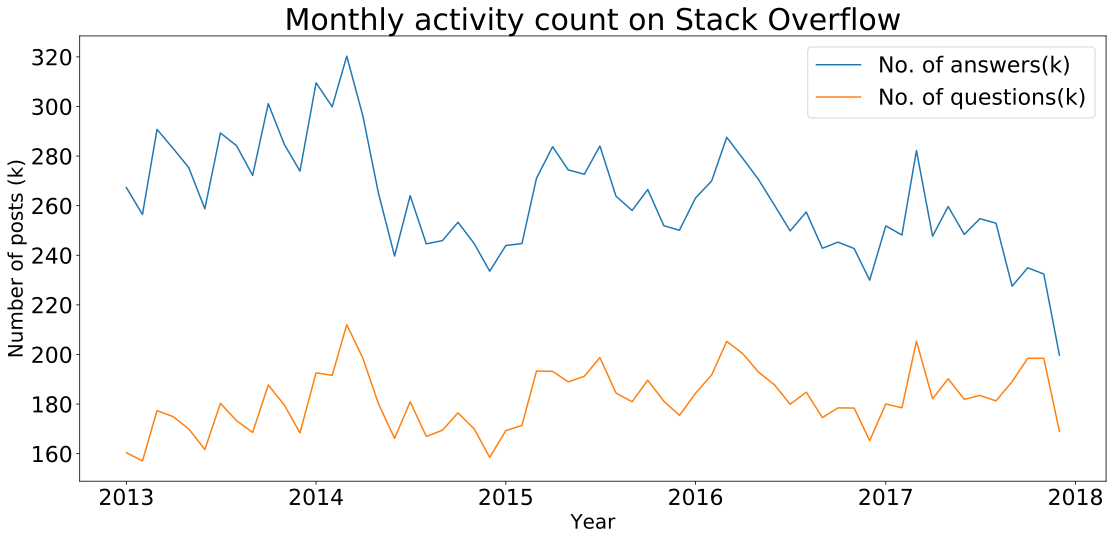

In [25]:
def y_fmt(x, y):
    return '{:2.1e}'.format(x)

fig = plt.figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(111)
plt.plot(all_activity_count.creation_month, all_activity_count.answer_count, label='No. of answers(k)')
plt.plot(all_activity_count.creation_month, all_activity_count.question_count, label='No. of questions(k)')
#plt.plot(all_activity_count.creation_month, all_activity_count.comment_count , label='No. of comments')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of posts (k)', fontsize=20)
plt.title('Monthly activity count on Stack Overflow', fontsize=30)
plt.legend()

#ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(y_fmt))

ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
#ax.margins(0.05)
#ax.axis('tight')
fig.tight_layout()
plt.show()
fig.savefig('./data/img/Monthly_Activity.png')

In [15]:
answer_count_trend['creation_year'] = answer_count_trend['creation_month'].apply(lambda x:x[:4])

In [20]:
answer_count_last5years = answer_count_trend[(answer_count_trend['creation_year'].astype(int)>2012) & (answer_count_trend['creation_year'].astype(int)<2018)]

In [21]:
answer_count_last5years.groupby('creation_year')

,creation_month,answer_count,year,creation_year
23,201301,267308,2013,2013
2,201302,256454,2013,2013
9,201303,290754,2013,2013
48,201304,283059,2013,2013
13,201305,275362,2013,2013
26,201306,258740,2013,2013
54,201307,289300,2013,2013
70,201308,284174,2013,2013
110,201309,272206,2013,2013
93,201310,301127,2013,2013


## Corhort analysis

In [46]:
view_ref = dataset_ref.table('SO_cohort_items_2017_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
  id,
  FORMAT_TIMESTAMP('%Y%m', creation_date) AS signup_month
FROM
  `bigquery-public-data.stackoverflow.users`
WHERE
  CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) = 2017
ORDER BY
  id,
  FORMAT_TIMESTAMP('%Y%m', creation_date)
"""
view = client.create_table(view)

In [42]:
view_ref = dataset_ref.table('SO_answerer_activity_2017_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
answer.owner_user_id AS id,
(CAST(FORMAT_TIMESTAMP('%m',
  answer.creation_date) AS int64) - cohort_items.signup_month) AS month_number
FROM
`bigquery-public-data.stackoverflow.posts_answers` AS answer
LEFT JOIN
`stackoverflow-metis.SO_dataset.SO_cohort_items_2017_view` AS cohort_items
ON
answer.id = cohort_items.id
WHERE
CAST(FORMAT_TIMESTAMP('%Y',
      answer.creation_date) AS int64) = 2017
GROUP BY
1,
2
"""
view = client.create_table(view)

In [48]:
view_ref = dataset_ref.table('SO_answerer_month_number_2017_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
WITH activity_signup AS(
SELECT
  answer.owner_user_id AS id,
  CAST(FORMAT_TIMESTAMP('%m', answer.creation_date) AS int64) AS activity_month,
  MIN(CAST(SUBSTR(cohort_items.signup_month, 5,6) AS int64)) AS signup_month
FROM
  `bigquery-public-data.stackoverflow.posts_answers` AS answer
LEFT JOIN
  `stackoverflow-metis.SO_dataset.SO_cohort_items_2017_view` AS cohort_items
ON
  answer.owner_user_id = cohort_items.id
WHERE
  CAST(FORMAT_TIMESTAMP('%Y', answer.creation_date) AS int64) = 2017
GROUP BY
1,2) SELECT DISTINCT id, (activity_month - signup_month) AS month_number
FROM activity_signup
WHERE signup_month is not NULL
"""
view = client.create_table(view)

In [49]:
query = """
#standardSQL
WITH
  retention_table AS (
  SELECT
    cohort_items.signup_month,
    user_activities.month_number,
    COUNT(1) AS num_users
  FROM
    `stackoverflow-metis.SO_dataset.SO_answerer_month_number_2017_view` AS user_activities
  LEFT JOIN
    `stackoverflow-metis.SO_dataset.SO_cohort_items_2017_view` AS cohort_items
  ON
    user_activities.id = cohort_items.id
  GROUP BY
    1,
    2 )
SELECT
  retention_table.signup_month,
  cohort_size.num_users AS total_users,
  retention_table.month_number,
  retention_table.num_users*100/ cohort_size.num_users AS percentage
FROM
  retention_table
LEFT JOIN (
  SELECT
    signup_month AS cohort_month,
    COUNT(signup_month) AS num_users
  FROM
    `stackoverflow-metis.SO_dataset.SO_cohort_items_2017_view`
  GROUP BY
    signup_month
  ORDER BY
    signup_month) AS cohort_size
ON
  cohort_size.cohort_month = retention_table.signup_month
WHERE
  retention_table.signup_month IS NOT NULL
ORDER BY
  1,
  3
  """
query_job = client.query(query)
results = query_job.result()
corhort_analysis = results.to_dataframe()

In [52]:
corhort_analysis.to_csv('./data/processed/cohort.analysis.csv')

## Cohort Analysis by Year

In [53]:
view_ref = dataset_ref.table('SO_cohort_items_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
  id,
  CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) AS signup_year
FROM
  `bigquery-public-data.stackoverflow.users`
WHERE
  CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) >= 2008 AND
  CAST(FORMAT_TIMESTAMP('%Y', creation_date) AS int64) < 2018
ORDER BY
  1,2
"""
view = client.create_table(view)

In [54]:
view_ref = dataset_ref.table('SO_answerer_year_number_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
WITH
  activity_signup AS(
  SELECT
    answer.owner_user_id AS id,
    CAST(FORMAT_TIMESTAMP('%Y', answer.creation_date) AS int64) AS activity_year,
    MIN(cohort_items.signup_year) AS signup_year
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` AS answer
  LEFT JOIN
    `stackoverflow-metis.SO_dataset.SO_cohort_items_view` AS cohort_items
  ON
    answer.owner_user_id = cohort_items.id
  WHERE
      CAST(FORMAT_TIMESTAMP('%Y', answer.creation_date) AS int64) >= 2008 AND
      CAST(FORMAT_TIMESTAMP('%Y', answer.creation_date) AS int64) < 2018
  GROUP BY
    1,
    2)
SELECT
  DISTINCT id,
  (activity_year - signup_year) AS year_number
FROM
  activity_signup
WHERE
  signup_year IS NOT NULL
"""
view = client.create_table(view)

In [55]:
query = """
#standardSQL
WITH
  retention_table AS (
  SELECT
    cohort_items.signup_year,
    user_activities.year_number,
    COUNT(1) AS num_users
  FROM
    `stackoverflow-metis.SO_dataset.SO_answerer_year_number_view` AS user_activities
  LEFT JOIN
    `stackoverflow-metis.SO_dataset.SO_cohort_items_view` AS cohort_items
  ON
    user_activities.id = cohort_items.id
  GROUP BY
    1,
    2 )
SELECT
  retention_table.signup_year,
  cohort_size.num_users AS total_users,
  retention_table.year_number,
  retention_table.num_users*100/ cohort_size.num_users AS percentage
FROM
  retention_table
LEFT JOIN (
  SELECT
    signup_year AS cohort_year,
    COUNT(signup_year) AS num_users
  FROM
    `stackoverflow-metis.SO_dataset.SO_cohort_items_view`
  GROUP BY
    signup_year
  ORDER BY
    signup_year) AS cohort_size
ON
  cohort_size.cohort_year = retention_table.signup_year
WHERE
  retention_table.signup_year IS NOT NULL
ORDER BY
  1,
  3
  """
query_job = client.query(query)
results = query_job.result()
corhort_analysis_year = results.to_dataframe()

In [57]:
corhort_analysis_year.to_csv('./data/processed/cohort_analysis_year.csv')

## LCV analysis for customers registered between 2016 Jan and June

### Reconstruct user reputation

In [50]:
query = """
#standardSQL
SELECT
  id
FROM 
  `bigquery-public-data.stackoverflow.users` AS user
WHERE
  CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) >= 201601
  AND CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201606

"""
query_job = client.query(query)
results = query_job.result()
lcv_id = results.to_dataframe()

lcv_id.dropna(inplace=True)
lcv_id['id'] = lcv_accepted['id'].astype(int)
lcv_id.sort_values('id',inplace=True)

with open('./data/processed/lcv_id.pkl', 'wb') as picklefile:
    pickle.dump(lcv_id, picklefile)

In [43]:
with open('./data/processed/lcv_id.pkl', 'rb') as picklefile:
    lcv_id = pickle.load(picklefile)

In [65]:
### Construct a timeseries where columns are sum of answer scores for each user per month
query = """
#standardsql
WITH
  answer_times AS (
  SELECT
    owner_user_id AS id,
    score,
    FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2016'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2018' )
SELECT
  id,
  SUM(IF(creation_time = "201601", score, NULL)) as m_201601,
  SUM(IF(creation_time = "201602", score, NULL)) as m_201602,
  SUM(IF(creation_time = "201603", score, NULL)) as m_201603,
  SUM(IF(creation_time = "201604", score, NULL)) as m_201604,
  SUM(IF(creation_time = "201605", score, NULL)) as m_201605,
  SUM(IF(creation_time = "201606", score, NULL)) as m_201606,
  SUM(IF(creation_time = "201607", score, NULL)) as m_201607,
  SUM(IF(creation_time = "201608", score, NULL)) as m_201608,
  SUM(IF(creation_time = "201609", score, NULL)) as m_201609,
  SUM(IF(creation_time = "201610", score, NULL)) as m_201610,
  SUM(IF(creation_time = "201611", score, NULL)) as m_201611,
  SUM(IF(creation_time = "201612", score, NULL)) as m_201612,
  SUM(IF(creation_time = "201701", score, NULL)) as m_201701,
  SUM(IF(creation_time = "201702", score, NULL)) as m_201702,
  SUM(IF(creation_time = "201703", score, NULL)) as m_201703,
  SUM(IF(creation_time = "201704", score, NULL)) as m_201704,
  SUM(IF(creation_time = "201705", score, NULL)) as m_201705,
  SUM(IF(creation_time = "201706", score, NULL)) as m_201706,
  SUM(IF(creation_time = "201707", score, NULL)) as m_201707,
  SUM(IF(creation_time = "201708", score, NULL)) as m_201708,
  SUM(IF(creation_time = "201709", score, NULL)) as m_201709,
  SUM(IF(creation_time = "201710", score, NULL)) as m_201710,
  SUM(IF(creation_time = "201711", score, NULL)) as m_201711,
  SUM(IF(creation_time = "201712", score, NULL)) as m_201712,
  SUM(IF(creation_time = "201801", score, NULL)) as m_201801,
  SUM(IF(creation_time = "201802", score, NULL)) as m_201802,
  SUM(IF(creation_time = "201803", score, NULL)) as m_201803,
  SUM(IF(creation_time = "201804", score, NULL)) as m_201804,
  SUM(IF(creation_time = "201805", score, NULL)) as m_201805,
  SUM(IF(creation_time = "201806", score, NULL)) as m_201806
FROM
  answer_times
WHERE
  id IN (
  SELECT
    id
  FROM
    `bigquery-public-data.stackoverflow.users` AS user
  WHERE
    CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) >= 201601
    AND CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201606)
GROUP BY
  id
ORDER BY
  id
"""
query_job = client.query(query)
results = query_job.result()
lcv_answer = results.to_dataframe()
lcv_answer = pd.merge(lcv_id, lcv_answer, how='left', left_on='id', right_on='id')
lcv_answer.fillna(0,inplace=True)
with open('./data/processed/lcv_answer.pkl', 'wb') as picklefile:
    pickle.dump(lcv_answer, picklefile)

In [35]:
with open('./data/processed/lcv_answer.pkl', 'rb') as picklefile:
    lcv_answer = pickle.load(picklefile)

In [68]:
### Construct a timeseries where columns are question scores for each user per month
query = """
#standardsql
WITH
  question_times AS (
  SELECT
    owner_user_id AS id,
    score,
    FORMAT_TIMESTAMP('%Y%m', creation_date) AS creation_time
  FROM
    `bigquery-public-data.stackoverflow.posts_questions`
  WHERE
    FORMAT_TIMESTAMP('%Y', creation_date) = '2016'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2017'
    OR FORMAT_TIMESTAMP('%Y', creation_date) = '2018' )
SELECT
  id,
  SUM(IF(creation_time = "201601", score, NULL)) as m_201601,
  SUM(IF(creation_time = "201602", score, NULL)) as m_201602,
  SUM(IF(creation_time = "201603", score, NULL)) as m_201603,
  SUM(IF(creation_time = "201604", score, NULL)) as m_201604,
  SUM(IF(creation_time = "201605", score, NULL)) as m_201605,
  SUM(IF(creation_time = "201606", score, NULL)) as m_201606,
  SUM(IF(creation_time = "201607", score, NULL)) as m_201607,
  SUM(IF(creation_time = "201608", score, NULL)) as m_201608,
  SUM(IF(creation_time = "201609", score, NULL)) as m_201609,
  SUM(IF(creation_time = "201610", score, NULL)) as m_201610,
  SUM(IF(creation_time = "201611", score, NULL)) as m_201611,
  SUM(IF(creation_time = "201612", score, NULL)) as m_201612,
  SUM(IF(creation_time = "201701", score, NULL)) as m_201701,
  SUM(IF(creation_time = "201702", score, NULL)) as m_201702,
  SUM(IF(creation_time = "201703", score, NULL)) as m_201703,
  SUM(IF(creation_time = "201704", score, NULL)) as m_201704,
  SUM(IF(creation_time = "201705", score, NULL)) as m_201705,
  SUM(IF(creation_time = "201706", score, NULL)) as m_201706,
  SUM(IF(creation_time = "201707", score, NULL)) as m_201707,
  SUM(IF(creation_time = "201708", score, NULL)) as m_201708,
  SUM(IF(creation_time = "201709", score, NULL)) as m_201709,
  SUM(IF(creation_time = "201710", score, NULL)) as m_201710,
  SUM(IF(creation_time = "201711", score, NULL)) as m_201711,
  SUM(IF(creation_time = "201712", score, NULL)) as m_201712,
  SUM(IF(creation_time = "201801", score, NULL)) as m_201801,
  SUM(IF(creation_time = "201802", score, NULL)) as m_201802,
  SUM(IF(creation_time = "201803", score, NULL)) as m_201803,
  SUM(IF(creation_time = "201804", score, NULL)) as m_201804,
  SUM(IF(creation_time = "201805", score, NULL)) as m_201805,
  SUM(IF(creation_time = "201806", score, NULL)) as m_201806
FROM
  question_times
WHERE
  id IN (
  SELECT
    id
  FROM
    `bigquery-public-data.stackoverflow.users` AS user
  WHERE
    CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) >= 201601
    AND CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201606)
GROUP BY
  id
ORDER BY
  id
"""
query_job = client.query(query)
results = query_job.result()
lcv_question = results.to_dataframe()
lcv_question = pd.merge(lcv_id, lcv_question, how='left', left_on='id', right_on='id')
lcv_question.fillna(0, inplace=True)
with open('./data/processed/lcv_question.pkl', 'wb') as picklefile:
    pickle.dump(lcv_question, picklefile)

In [45]:
with open('./data/processed/lcv_question.pkl', 'rb') as picklefile:
    lcv_question = pickle.load(picklefile)

In [66]:
### Construct a timeseries where columns are number of accepted answers for each user per month
query = """
#standardSQL
WITH
  accepted_answer AS (
  SELECT
    answer.owner_user_id AS id,
    FORMAT_TIMESTAMP('%Y%m', answer.creation_date) AS creation_time
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` AS answer
  LEFT JOIN
    `bigquery-public-data.stackoverflow.posts_questions` AS question
  ON
    answer.parent_id = question.id
  WHERE
    answer.id = question.accepted_answer_id
    AND FORMAT_TIMESTAMP('%Y', answer.creation_date) = '2016'
    OR FORMAT_TIMESTAMP('%Y', answer.creation_date) = '2017'
    OR FORMAT_TIMESTAMP('%Y', answer.creation_date) = '2018')
SELECT
  accepted_answer.id,
  COUNT(IF(creation_time = "201601", accepted_answer.id, NULL)) as m_201601,
  COUNT(IF(creation_time = "201602", accepted_answer.id, NULL)) as m_201602,
  COUNT(IF(creation_time = "201603", accepted_answer.id, NULL)) as m_201603,
  COUNT(IF(creation_time = "201604", accepted_answer.id, NULL)) as m_201604,
  COUNT(IF(creation_time = "201605", accepted_answer.id, NULL)) as m_201605,
  COUNT(IF(creation_time = "201606", accepted_answer.id, NULL)) as m_201606,
  COUNT(IF(creation_time = "201607", accepted_answer.id, NULL)) as m_201607,
  COUNT(IF(creation_time = "201608", accepted_answer.id, NULL)) as m_201608,
  COUNT(IF(creation_time = "201609", accepted_answer.id, NULL)) as m_201609,
  COUNT(IF(creation_time = "201610", accepted_answer.id, NULL)) as m_201610,
  COUNT(IF(creation_time = "201611", accepted_answer.id, NULL)) as m_201611,
  COUNT(IF(creation_time = "201612", accepted_answer.id, NULL)) as m_201612,
  COUNT(IF(creation_time = "201701", accepted_answer.id, NULL)) as m_201701,
  COUNT(IF(creation_time = "201702", accepted_answer.id, NULL)) as m_201702,
  COUNT(IF(creation_time = "201703", accepted_answer.id, NULL)) as m_201703,
  COUNT(IF(creation_time = "201704", accepted_answer.id, NULL)) as m_201704,
  COUNT(IF(creation_time = "201705", accepted_answer.id, NULL)) as m_201705,
  COUNT(IF(creation_time = "201706", accepted_answer.id, NULL)) as m_201706,
  COUNT(IF(creation_time = "201707", accepted_answer.id, NULL)) as m_201707,
  COUNT(IF(creation_time = "201708", accepted_answer.id, NULL)) as m_201708,
  COUNT(IF(creation_time = "201709", accepted_answer.id, NULL)) as m_201709,
  COUNT(IF(creation_time = "201710", accepted_answer.id, NULL)) as m_201710,
  COUNT(IF(creation_time = "201711", accepted_answer.id, NULL)) as m_201711,
  COUNT(IF(creation_time = "201712", accepted_answer.id, NULL)) as m_201712,
  COUNT(IF(creation_time = "201801", accepted_answer.id, NULL)) as m_201801,
  COUNT(IF(creation_time = "201802", accepted_answer.id, NULL)) as m_201802,
  COUNT(IF(creation_time = "201803", accepted_answer.id, NULL)) as m_201803,
  COUNT(IF(creation_time = "201804", accepted_answer.id, NULL)) as m_201804,
  COUNT(IF(creation_time = "201805", accepted_answer.id, NULL)) as m_201805,
  COUNT(IF(creation_time = "201806", accepted_answer.id, NULL)) as m_201806
FROM
  accepted_answer
RIGHT JOIN
  `bigquery-public-data.stackoverflow.users` AS user
ON
  user.id = accepted_answer.id AND
  CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) >= 201601
  AND CAST(FORMAT_TIMESTAMP('%Y%m', user.creation_date) AS int64) <= 201606
GROUP BY
  accepted_answer.id
ORDER BY
  accepted_answer.id
"""
query_job = client.query(query)
results = query_job.result()
lcv_accepted = results.to_dataframe()

lcv_accepted.dropna(inplace=True)
lcv_accepted['id'] = lcv_accepted['id'].astype(int)
lcv_accepted = pd.merge(lcv_id, lcv_accepted, how='left', left_on='id', right_on='id')
lcv_accepted.fillna(0, inplace=True)

with open('./data/processed/lcv_accepted.pkl', 'wb') as picklefile:
    pickle.dump(lcv_accepted, picklefile)

In [11]:
with open('./data/processed/lcv_accepted.pkl', 'rb') as picklefile:
    lcv_accepted = pickle.load(picklefile)
lcv_accepted.shape

(764974, 31)

In [85]:
lcv_question.set_index('id', inplace=True)
lcv_answer.set_index('id', inplace=True)
lcv_accepted.set_index('id', inplace=True)
lcv_reputation = lcv_question*5 + lcv_answer*10 + lcv_accepted*15
with open('./data/processed/lcv_reputation.pkl', 'wb') as picklefile:
    pickle.dump(lcv_reputation, picklefile)

In [37]:
def build_timeseries(df):
    ts_colname = ['M', 'M+1', 'M+2', 'M+3',
             'M+4', 'M+5', 'M+6', 'M+7',
             'M+8', 'M+9', 'M+10', 'M+11',
             'M+12', 'M+13', 'M+14', 'M+15',
             'M+16','M+17','M+18','M+19',
             'M+20','M+21','M+22','M+23']
    df_2year = df[df['creation_month'] == 1].iloc[:,0:24]
    df_2year.columns = ts_colname
    print ('round 1 - added', df_2year.shape[0], 'rows')
    for val in range(2,7):
        eligible_values = df[df['creation_month'] == val].iloc[:,(val-1):(val+23)]
        eligible_values.columns=ts_colname
        df_2year = pd.concat([df_2year, eligible_values])
        print ('round', val, '- added', eligible_values.shape[0], 'rows')
    return df_2year

In [134]:
lcv_reputation['creation_month'] = pd.merge(lcv_id, user_basic['creation_month'].to_frame(), how='left', left_on='id', right_index=True)['creation_month'].values
lcv_2years = build_timeseries(lcv_reputation)
with open('./data/processed/lcv_2years.pkl', 'wb') as picklefile:
    pickle.dump(lcv_2years, picklefile)

round 1 - added 125341 rows
round 2 - added 124555 rows
round 3 - added 137197 rows
round 4 - added 129055 rows
round 5 - added 125746 rows
round 6 - added 123080 rows


In [44]:
lcv_answer['creation_month'] = pd.merge(lcv_id, user_basic['creation_month'].to_frame(), how='left', left_on='id', right_index=True)['creation_month'].values
lcv_answer_2years = build_timeseries(lcv_answer)
with open('./data/processed/lcv_answer_2years.pkl', 'wb') as picklefile:
    pickle.dump(lcv_answer_2years, picklefile)

round 1 - added 125341 rows
round 2 - added 124555 rows
round 3 - added 137197 rows
round 4 - added 129055 rows
round 5 - added 125746 rows
round 6 - added 123080 rows


In [50]:
lcv_question.set_index('id', inplace=True)
lcv_question['creation_month'] = pd.merge(lcv_id, user_basic['creation_month'].to_frame(), how='left', left_on='id', right_index=True)['creation_month'].values
lcv_question_2years = build_timeseries(lcv_question)
with open('./data/processed/lcv_question_2years.pkl', 'wb') as picklefile:
    pickle.dump(lcv_question_2years, picklefile)

round 1 - added 125341 rows
round 2 - added 124555 rows
round 3 - added 137197 rows
round 4 - added 129055 rows
round 5 - added 125746 rows
round 6 - added 123080 rows
